# Volatility Trading with VIX Forecasting

Sean Lin, Thomas McDonnell, Benjamin Panovich, Madison Rusch

In [1]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import wrds 

import data_collection 
import model_building
import trading_strategy

import warnings 
warnings.filterwarnings('ignore')

In [2]:
KEY = os.getenv('QUANDL_KEY')
conn = wrds.Connection(wrds_username='seanl59')

Loading library list...
Done


## 1. Introduction

> Introduction

***

## 2. Building the Model

> Overview

I'm setting the parameters for the Data Collection class here

In [3]:
START_DATE, END_DATE = '2014-01-01', '2021-12-31'
YEARS = ['2014','2015','2016','2017','2018','2019','2020','2021','2022']
MONTH_CODES = ['H','M','U','Z']
DataCollection = data_collection.DataCollection(KEY,START_DATE,END_DATE,YEARS,MONTH_CODES) # Class for data collection 

In [4]:
vix_data = pd.read_csv('./data/vix_data.csv',index_col=0,parse_dates=True) # Downloading processed data 
raw_calendar_data = pd.read_csv('./data/calendar_raw.csv',index_col=0,parse_dates=True)
eafe_data = pd.read_csv('./data/eafe_data.csv',index_col=0,parse_dates=True)
spy_data = DataCollection.fetch_quandl_table('QUOTEMEDIA/PRICES','SPY')

calendar_data = DataCollection.convert_calendar(raw_calendar_data,vix_data) # Converting raw calendar data to processed data 
predictors = pd.concat([vix_data,eafe_data,spy_data,calendar_data],axis=1)

predictors['VIX Returns'] = predictors['VIX'].pct_change().shift(-1) # Shifting data
predictors['SPY Returns'] = predictors['close'].pct_change() 
predictors['EAFE Returns'] = predictors['EAFE'].pct_change()
predictors['Days until Event'] = predictors['Days until Event'].shift(-1)
predictors['Volume Change'] = predictors['volume'].pct_change()
predictors = predictors[['VIX Returns','SPY Returns','EAFE Returns','Days until Event','Volume Change']].dropna()

In [7]:
Model = model_building.Model(predictors,126)
Model.train_model()

100%|██████████| 1887/1887 [02:30<00:00, 12.58it/s]


Someone convert these to gg plots to a new grid. these are the p-values (notable thresholds are 0.05 and 0.01, lower is better)

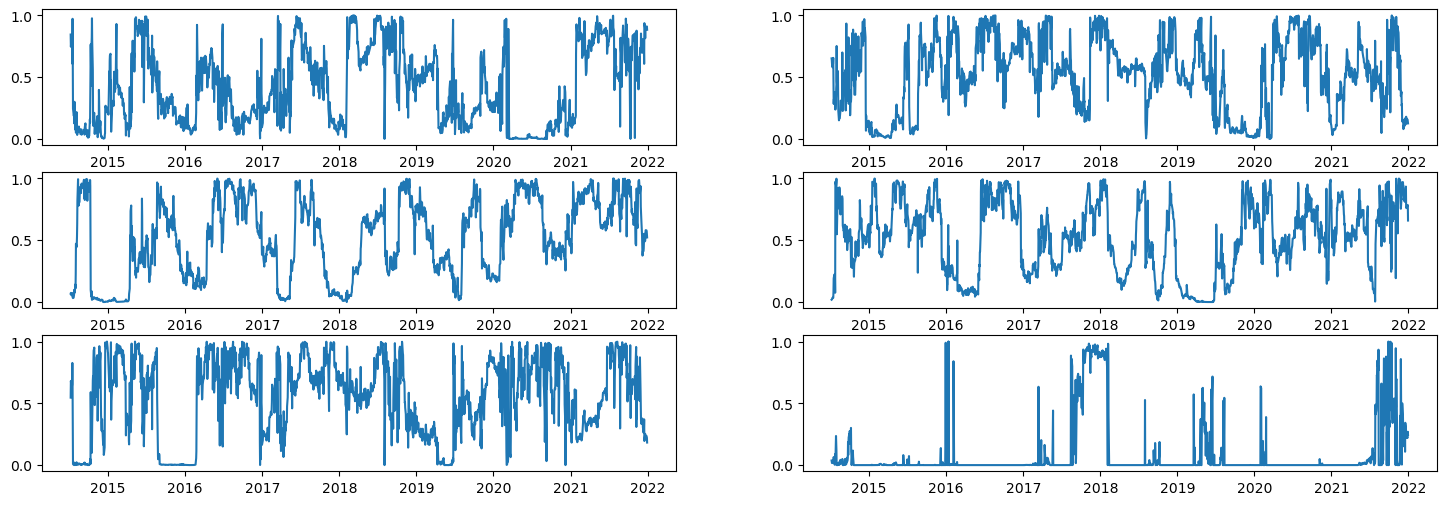

In [8]:
fig, ax = plt.subplots(3,2,figsize=(18,6))
ax[0,0].plot(Model.pvalues['SPY Returns'])
ax[0,1].plot(Model.pvalues['EAFE Returns'])
ax[1,0].plot(Model.pvalues['Days until Event'])
ax[1,1].plot(Model.pvalues['Volume Change'])
ax[2,0].plot(Model.pvalues['AR'])
ax[2,1].plot(Model.pvalues['MA'])

In [9]:
Model.performance_metrics(0.75,0.25)
metrics = Model.metrics
metrics 

,MSE,DA,Up Acc,Down Acc,Prediction Num
Metrics,0.009251,0.479067,0.520408,0.625,130


In [10]:
#predicted_results = Model.predicted_results
#predicted_results.dropna().to_csv('model_temp.csv')

In [5]:
predicted_results = pd.read_csv('model_temp.csv',index_col=0,parse_dates=True) # Temporary file so i don't have to re-run the ARIMA 
predicted_results.head()

,predictions,actual,upper threshold,lower threshold
2015-01-02,0.012179,0.119730,0.052814,-0.041584
2015-01-05,0.004021,0.060241,0.052814,-0.041584
2015-01-06,0.004387,-0.085701,0.057105,-0.041584
2015-01-07,0.038672,-0.119109,0.052814,-0.043513
2015-01-08,-0.030023,0.031746,0.052814,-0.044496


still need to add more analysis in this section, but this is the general gist of it. statistical analysis here is best

***

In [6]:
options_chain = pd.read_csv('options_chain.csv',index_col=0,parse_dates=True)

In [7]:
TradingStrategy = trading_strategy.TradingStrategy(predicted_results,0,spy_data,conn,options_chain)
TradingStrategy.create_signals()
TradingStrategy.signals.to_csv('signals.csv')

In [8]:
gc_data = pd.read_csv('./data/gc_data.csv',index_col=0,parse_dates=True)
tlt_data = pd.read_csv('./data/tlt_data.csv',index_col=0,parse_dates=True)
cl_data = pd.read_csv('./data/cl_data.csv',index_col=0,parse_dates=True)
si_data = pd.read_csv('./data/si_data.csv',index_col=0,parse_dates=True)

In [9]:
TradingStrategy.obtain_chain()

Options chain already stored. Use TradingStrategy.options_chain


In [53]:
res = TradingStrategy.backtest_options(how_far=3)

<AxesSubplot: >

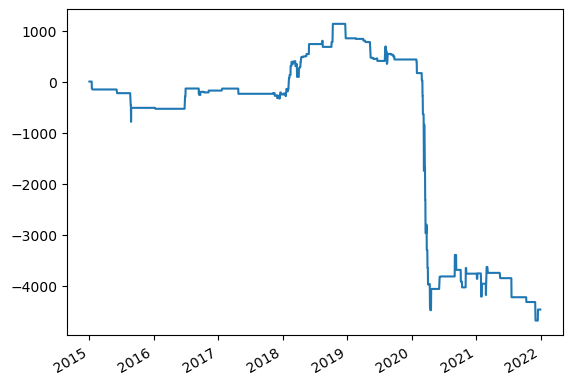

In [54]:
res['Daily PnL'].cumsum().plot()

In [55]:
deltas = res[['Delta']]
deltas

,Delta
2015-01-02,0.0
2015-01-05,0.0
2015-01-06,0.0
2015-01-07,0.0
2015-01-08,0.0
...,...
2021-12-23,0.0
2021-12-27,0.0
2021-12-28,0.0
2021-12-29,0.0


In [56]:
dates = TradingStrategy.signals.index
cur_signal = 0 
cur_pos = 0 
prev_price = 0 
DIR = -1 

delta_hedge_rets = pd.DataFrame(index=dates)
for i in dates:
    date_signal = TradingStrategy.signals.loc[i, 'signal']
    cur_price = spy_data.loc[i, 'close']

    daily_pnl = cur_pos * (cur_price - prev_price) 

    if date_signal != cur_signal: 
        if date_signal != 0: # Open a new position 
            cur_pos = np.abs(deltas.loc[i].item()) * date_signal * DIR 
            cur_signal = date_signal 
            prev_price = cur_price  
        else: # Close the position 
            cur_pos, cur_signal = 0, 0

    delta_hedge_rets.loc[i, 'Daily PnL'] = daily_pnl 


In [57]:
opts = res['Daily PnL'].cumsum()
opts = opts.to_frame('Daily PnL')

In [58]:
d = delta_hedge_rets.cumsum()

In [59]:
d

,Daily PnL
2015-01-02,0.000000
2015-01-05,0.000000
2015-01-06,0.000000
2015-01-07,0.000000
2015-01-08,0.000000
...,...
2021-12-23,4794.460187
2021-12-27,4794.460187
2021-12-28,4794.460187
2021-12-29,4794.460187


In [60]:
d['Daily PnL'] + opts['Daily PnL']

2015-01-02      0.000000
2015-01-05      0.000000
2015-01-06      0.000000
2015-01-07      0.000000
2015-01-08      0.000000
                 ...    
2021-12-23    324.960187
2021-12-27    324.960187
2021-12-28    324.960187
2021-12-29    324.960187
2021-12-30    324.960187
Name: Daily PnL, Length: 1762, dtype: float64

<AxesSubplot: >

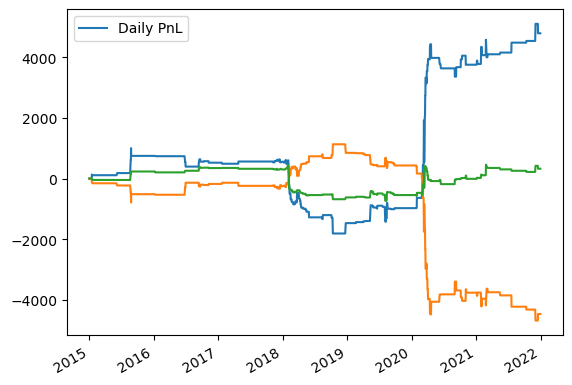

In [61]:
delta_hedge_rets.cumsum().plot()
res['Daily PnL'].cumsum().plot()
(d['Daily PnL'] + opts['Daily PnL']).plot()